In [10]:
import pandas as pd
import numpy as np

from sklearn.svm import SVR, LinearSVR
from sklearn.grid_search import GridSearchCV
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer
from time import time
from sklearn import svm
from sklearn import cross_validation

import MHR as mhr

def simple_spearman(x,y): return np.abs(spearmanr(x,y)[0])
spearmanr_scorer = make_scorer(simple_spearman)

In [11]:
def reload_package(root_module):
    package_name = root_module.__name__

    # get a reference to each loaded module
    loaded_package_modules = dict([
        (key, value) for key, value in sys.modules.items() 
        if key.startswith(package_name) and isinstance(value, types.ModuleType)])

    # delete references to these loaded modules from sys.modules
    for key in loaded_package_modules:
        del sys.modules[key]

    # load each of the modules again; 
    # make old modules share state with new modules
    for key in loaded_package_modules:
        print 'loading %s' % key
        newmodule = __import__(key)
        oldmodule = loaded_package_modules[key]
        oldmodule.__dict__.clear()
        oldmodule.__dict__.update(newmodule.__dict__)
        
def dcg_at_k(r, k, method=0):
    """Score is discounted cumulative gain (dcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> dcg_at_k(r, 1)
    3.0
    >>> dcg_at_k(r, 1, method=1)
    3.0
    >>> dcg_at_k(r, 2)
    5.0
    >>> dcg_at_k(r, 2, method=1)
    4.2618595071429155
    >>> dcg_at_k(r, 10)
    9.6051177391888114
    >>> dcg_at_k(r, 11)
    9.6051177391888114
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=0):
    """Score is normalized discounted cumulative gain (ndcg)
    Relevance is positive real values.  Can use binary
    as the previous methods.
    Example from
    http://www.stanford.edu/class/cs276/handouts/EvaluationNew-handout-6-per.pdf
    >>> r = [3, 2, 3, 0, 0, 1, 2, 2, 3, 0]
    >>> ndcg_at_k(r, 1)
    1.0
    >>> r = [2, 1, 2, 0]
    >>> ndcg_at_k(r, 4)
    0.9203032077642922
    >>> ndcg_at_k(r, 4, method=1)
    0.96519546960144276
    >>> ndcg_at_k([0], 1)
    0.0
    >>> ndcg_at_k([1], 2)
    1.0
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Normalized discounted cumulative gain
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max


def calc_ndcg(df, column,k):
    min_votes=5
    min_comments=30

    ndcg_global=[]
    grouped=df.groupby('asin')

    for name, group in grouped:
        dffiltro = (df['asin']==name)
        
        values_test = df[dffiltro]['helpfulness'].T.to_dict().values()
        scores = df[dffiltro][column].T.to_dict().values()


        ind = (-np.array(scores)).argsort()
        a = np.array(values_test)[ind]	
        ndcg = ndcg_at_k(a, k)
        ndcg_global.append(ndcg)
    return ndcg_global

def calc_ndcg_mean(df, column,k):
    x = calc_ndcg(df,column,k)
    return np.mean(x)

def calc_corr(df, column):
    correlation=[]
    grouped=df.groupby('asin')

    for name, group in grouped:
        dffiltro = (df['asin']==name)
        
        helpfulness = df[dffiltro]['helpfulness'].T.to_dict().values()
        scores = df[dffiltro][column].T.to_dict().values()
        correlation.append(np.corrcoef(helpfulness,scores)[0][1])
    return correlation

In [12]:
reviews_features = pd.read_csv('data/book_sample_counts.csv.gz')
reviews_features.shape

(24234, 30)

In [13]:
reviews_features.columns

Index([u'Unnamed: 0', u'Unnamed: 0.1', u'Unnamed: 0.1', u'Unnamed: 0.1.1',
       u'Unnamed: 0.1.1', u'Unnamed: 0.1.1.1', u'asin', u'helpful', u'overall',
       u'reviewText', u'reviewTime', u'reviewerID', u'reviewerName',
       u'summary', u'unixReviewTime', u'helpfulness', u'tot', u'pageRank',
       u'hits', u'powerWithStar', u'word_count', u'pr_hs', u'pr_len',
       u'hs_len', u'pr_hs_len', u'sentence_count', u'unigram_count',
       u'pos_tag', u'adj', u'noun'],
      dtype='object')

In [14]:
df_columns = reviews_features.select_dtypes(include=['float64','int','int64']).columns
df_columns

Index([u'Unnamed: 0', u'Unnamed: 0.1', u'Unnamed: 0.1', u'Unnamed: 0.1.1',
       u'Unnamed: 0.1.1', u'Unnamed: 0.1.1.1', u'overall', u'unixReviewTime',
       u'helpfulness', u'tot', u'pageRank', u'hits', u'powerWithStar',
       u'word_count', u'pr_hs', u'pr_len', u'hs_len', u'pr_hs_len',
       u'sentence_count', u'unigram_count', u'adj', u'noun'],
      dtype='object')

In [15]:
#CROSVALIDATION BY PRODUCTION
clf = svm.SVR(epsilon=0.001)


products=[]
ndcg=[]
ind=0
bestSVMPrediction=pd.DataFrame()
max_ndcg=0
for name, group in reviews_features.groupby('asin'):
    products.append(name)
len(products)

rs = cross_validation.ShuffleSplit(len(products), n_iter=10, test_size=.1 , random_state=0)
for train_index, test_index in rs:
    dffilter_train = (reviews_features['asin'].isin(np.array(products)[train_index])) 
    dffilter_test = (reviews_features['asin'].isin(np.array(products)[test_index]))
    #train
    features_train = reviews_features[dffilter_train][list(['word_count','sentence_count','unigram_count','adj','noun'])].values
    labels_train = reviews_features[dffilter_train]["helpfulness"].values
    clf.fit(features_train, labels_train)
    
    #test
    features_test = reviews_features[dffilter_test][list(['word_count','sentence_count','unigram_count','adj','noun'])].values
    labels_test = reviews_features[dffilter_test]["helpfulness"].values
    x=clf.predict(features_test)
    
    dfTest= reviews_features[dffilter_test]
    dfTest['svm']=x
    local_ndcg = calc_ndcg_mean(dfTest,'svm',5)
    ndcg.append(local_ndcg)
    print "ndcg at fold "+str(ind)+" = "+ str(local_ndcg) 
    
    if (local_ndcg>max_ndcg):
        bestSVMPrediction=dfTest
    
    ind=ind+1

#save bestSVMPrediction on csv
bestSVMPrediction.to_csv('data/best_prediction_svm_book.csv')

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ndcg at fold 0 = 0.734023149772
ndcg at fold 1 = 0.723683258216
ndcg at fold 2 = 0.743888681298
ndcg at fold 3 = 0.734994682114
ndcg at fold 4 = 0.737205496182
ndcg at fold 5 = 0.711184404906
ndcg at fold 6 = 0.733168606615
ndcg at fold 7 = 0.733667070431
ndcg at fold 8 = 0.754848394416
ndcg at fold 9 = 0.714209806575


In [16]:
#CROSVALIDATION BY COMMENTS
clf = svm.SVR(epsilon=0.001)


rs = cross_validation.ShuffleSplit(len(reviews_features), n_iter=10, test_size=.2 , random_state=0)
ind=0
ndcg=[]
for train_index, test_index in rs:
    #train
    features_train = reviews_features.ix[train_index][list(['word_count','sentence_count','unigram_count','adj','noun'])].values
    labels_train = reviews_features.ix[train_index]["helpfulness"].values
    clf.fit(features_train, labels_train)
    
    #test
    features_test = reviews_features.ix[test_index][list(['word_count','sentence_count','unigram_count','adj','noun'])].values
    labels_test = reviews_features.ix[test_index]["helpfulness"].values
    x=clf.predict(features_test)
    
    dfTest= reviews_features.ix[test_index]
    dfTest['svm']=x
    local_ndcg = calc_ndcg(dfTest,'svm',5)
    ndcg.append(local_ndcg)
    print "ndcg at fold "+str(ind)+" = "+ str(local_ndcg)
    
    ind=ind+1


ndcg at fold 0 = [0.7319846079018868, 0.74432636021265453, 0.77143837504010926, 0.99999999999999989, 0.68777160549015781, 0.87272385370886352, 0.86408630575458312, 0.77643992973526943, 0.8641942981586358, 0.81636447860858208, 0.89224512505820064, 0.73234713664376483, 0.96141472160048247, 0.78434342235218812, 0.85608320774788749, 0.7019820959541212, 0.8682697850387876, 0.86570189877911841, 0.95075112722402488, 0.92562838940955028, 0.91463513461830681, 0.84994822473138287, 0.78663339878414928, 0.76131020458178011, 0.68267844417685886, 0.92846790737524054, 0.61899150053416152, 0.70674128352334131, 0.75332568227144192, 0.6805043551654455, 0.77217251860240399, 0.88853679896893034, 0.77199538937406442, 0.89153903799535983, 0.82590344573841135, 0.69515622102183139, 0.70730270588389743, 0.64349836796314253, 0.72682662927773856, 0.94163025832321212, 0.85098128784485449, 0.89688685194077677, 0.95393546293956977, 0.83243790899403614, 0.67448092290457684, 0.79264046072303351, 0.57838781502529735, 

In [17]:
print "fold " + str(np.argmax(ndcg)) 
count=0
for train_index, test_index in rs:
    if (count==int(np.argmax(ndcg))):
        
        #df=reviews_features.ix[test_index]
        df=reviews_features[reviews_features['asin'].isin(np.array(products)[test_index])]
        
        print (len(df))
        x=mhr.executeFromDf(df)

    count=count+1

fold 1395


In [18]:
len(x)

4847

In [19]:
import seaborn as sns
k=3

ndcg_mhr=calc_ndcg(bestSVMPrediction,'powerWithStar',k) 
corr_mhr=calc_corr(bestSVMPrediction,'powerWithStar') 
print "MHR ndcg="+str(np.mean(ndcg_mhr))

ndcg_svm=calc_ndcg(bestSVMPrediction,'svm',k) 
corr_svm=calc_corr(bestSVMPrediction,'svm') 

print "SVM ndcg="+str(np.mean(ndcg_svm))

print (len(ndcg_svm))
print (len(ndcg_mhr))

tip={}
tip['SVM']=ndcg_svm
tip['MHR']=ndcg_mhr
df = pd.DataFrame(tip)
ax = sns.boxplot(data=df)
ax = sns.swarmplot(data=df, color=".25")
ax.set_title('NDCG@'+str(k))




/usr/local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


MHR ndcg=0.744730939259
SVM ndcg=0.701879199862
47
47


{'boxes': [<matplotlib.lines.Line2D at 0x113477c10>,
 'caps': [<matplotlib.lines.Line2D at 0x11347cb50>,
 'fliers': [<matplotlib.lines.Line2D at 0x113469e50>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x113469810>,
 'whiskers': [<matplotlib.lines.Line2D at 0x113477e10>,
  <matplotlib.lines.Line2D at 0x11344c150>]}

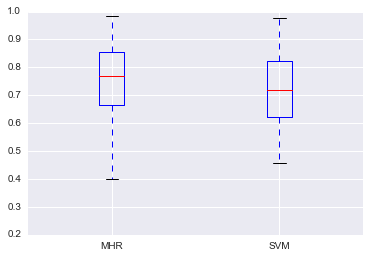

In [20]:
import matplotlib.pyplot as plt 
%matplotlib inline
#import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)

# Create a figure instance

# Create an axes instance

data_to_plot = [ ndcg_mhr,ndcg_svm ]

# Create the boxplot
plt.boxplot(data_to_plot, labels=["MHR","SVM"])


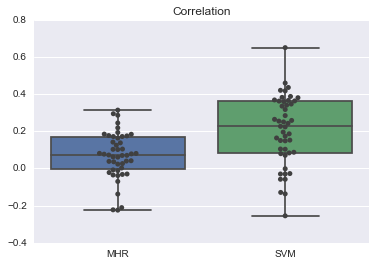

In [21]:
tip={}
tip['SVM']=corr_svm
tip['MHR']=corr_mhr
dftip=pd.DataFrame(tip)
#dftip.head()
ax = sns.boxplot(data=dftip)
ax = sns.swarmplot(data=dftip, color=".25")

ax.set_title('Correlation')

# Proof correctness - ndcg_at_k

In [33]:
df_agg = reviews_features[['word_count','asin']].groupby(['asin']).agg(['count','mean'])
df_agg['word_count'].sort_values('count',ascending=False).head(5)

,count,mean
asin,,
0345504968,147,300.122449
0060817089,147,214.666667
0060537639,146,264.472603
014118776X,144,277.631944
0061472786,137,377.474453


In [34]:
#MATRIX HELPFULNESS EXTRACT FROM AMAZON
product_id='014118776X'
reviews_features[reviews_features['asin']==product_id]['helpfulness'].values

array([ 0.28571429,  0.5       ,  0.7       ,  1.        ,  0.83333333,
        0.        ,  0.07142857,  0.42857143,  0.42857143,  0.        ,
        0.875     ,  0.625     ,  0.33333333,  0.90909091,  0.86363636,
        0.25      ,  0.83333333,  0.66666667,  0.75      ,  0.        ,
        0.125     ,  0.83333333,  0.11111111,  0.44444444,  0.22222222,
        0.03125   ,  0.125     ,  0.66666667,  0.93333333,  0.83333333,
        0.06451613,  0.71428571,  0.83333333,  0.85714286,  0.71428571,
        0.08333333,  0.        ,  0.21428571,  0.0625    ,  0.15789474,
        0.71428571,  0.7       ,  0.21212121,  0.42857143,  0.90909091,
        0.25      ,  0.85294118,  0.75      ,  0.625     ,  0.94117647,
        0.71428571,  0.86363636,  0.9375    ,  0.06976744,  0.42857143,
        0.83333333,  0.83333333,  0.09090909,  0.        ,  0.        ,
        1.        ,  0.71428571,  0.85714286,  0.11111111,  0.8       ,
        0.68965517,  0.06521739,  1.        ,  0.07142857,  0.08

## MHR

In [35]:
#VALUES OBTAINED FROM MHR
product_id='014118776X'
reviews_features[reviews_features['asin']==product_id]['powerWithStar'].values

array([ 0.00694444,  0.00694444,  0.00573171,  0.01357803,  0.00451168,
        0.00974356,  0.00694444,  0.01273152,  0.01140998,  0.00694444,
        0.00170192,  0.00106252,  0.00819829,  0.00694444,  0.00174393,
        0.00694444,  0.00339053,  0.01236604,  0.02257623,  0.00252269,
        0.00694444,  0.01717466,  0.00264178,  0.00683561,  0.00694444,
        0.00506286,  0.00694444,  0.00107848,  0.01305304,  0.00694444,
        0.00694444,  0.00694444,  0.00694444,  0.00182387,  0.00805213,
        0.00203771,  0.00529552,  0.00143626,  0.00694444,  0.01986939,
        0.01616881,  0.00909697,  0.0060602 ,  0.00752866,  0.00218487,
        0.00694444,  0.00789167,  0.00758577,  0.00405102,  0.00453839,
        0.0131311 ,  0.00694444,  0.00818914,  0.00694444,  0.00171944,
        0.00694444,  0.00694444,  0.00655906,  0.00694444,  0.00694444,
        0.00109438,  0.01127967,  0.00612871,  0.00258313,  0.01438411,
        0.00135306,  0.00786558,  0.00889536,  0.00183903,  0.00

In [36]:
#SORT COMMENTS BY MHR RANK
ind=(-np.array(reviews_features[reviews_features['asin']==product_id]['powerWithStar'].values)).argsort()
comments_sorted=reviews_features[reviews_features['asin']==product_id]['helpfulness'].values[ind]
comments_sorted

array([ 0.75      ,  0.75      ,  0.15789474,  0.90849673,  0.83333333,
        0.83333333,  0.84615385,  0.71428571,  0.83333333,  0.71428571,
        0.71428571,  0.75      ,  0.88855422,  0.8       ,  1.        ,
        0.71428571,  0.93333333,  0.42857143,  0.66666667,  0.625     ,
        0.875     ,  0.42857143,  0.71428571,  0.69230769,  0.        ,
        0.66666667,  0.66666667,  0.69230769,  0.7       ,  0.96666667,
        1.        ,  0.9047619 ,  0.33333333,  0.9375    ,  0.8       ,
        0.75      ,  0.71428571,  0.85294118,  0.06521739,  0.75      ,
        0.79487179,  0.57142857,  1.        ,  0.42857143,  0.08333333,
        0.33333333,  0.06451613,  0.08333333,  0.58333333,  0.16666667,
        0.66666667,  0.        ,  0.66666667,  0.47058824,  0.        ,
        0.33333333,  0.14285714,  0.72727273,  0.22916667,  0.55555556,
        0.06382979,  0.0625    ,  0.28571429,  0.125     ,  0.5       ,
        0.07142857,  0.        ,  0.90909091,  0.25      ,  0.12

In [37]:
# ndcg_at_k 
ndcg_at_k(comments_sorted, 5)

0.67743758687140065

## SVM

In [40]:
df_agg = bestSVMPrediction[['word_count','asin']].groupby(['asin']).agg(['count','mean'])
df_agg['word_count'].sort_values('count',ascending=False).head(5)

,count,mean
asin,,
0060838728,121,249.165289
0060558288,115,329.695652
0061928127,91,205.076923
0140447571,87,321.367816
0385340990,85,255.517647


In [41]:
#VALUES OBTAINED FROM SVM
product_id = '0140447571'
bestSVMPrediction[bestSVMPrediction['asin']==product_id]['svm'].values

array([ 0.70171986,  0.79844506,  0.67096227,  0.70171986,  0.63446388,
        0.64387987,  0.65608283,  0.5833448 ,  0.62448478,  0.39679286,
        0.74762269,  0.31645104,  0.68962877,  0.41109903,  0.71561602,
        0.62415576,  0.70176379,  0.97163394,  0.74257589,  0.66444546,
        0.70761029,  0.81649779,  0.65682507,  0.3838498 ,  0.80996463,
        0.67343154,  0.77215709,  0.69893762,  0.57319932,  0.7559167 ,
        0.58266259,  0.70171983,  0.57727256,  0.6508383 ,  0.46150189,
        0.30906947,  0.70777669,  0.78942584,  0.66145071,  0.80936526,
        0.50772092,  0.5913128 ,  0.70171986,  0.78868592,  0.63593587,
        0.69924043,  0.4088059 ,  0.57134777,  0.70597194,  0.38756706,
        0.68349301,  0.7193673 ,  0.68891702,  0.67653298,  0.70172425,
        0.82039284,  0.35428153,  0.56677569,  0.77163987,  0.70171986,
        0.74195297,  0.44556658,  0.62753364,  0.7017227 ,  0.52916261,
        0.7034576 ,  0.68772545,  0.76011102,  0.4706982 ,  0.31

In [42]:
#SORT COMMENTS BY SVM RANK
ind=(-np.array(bestSVMPrediction[bestSVMPrediction['asin']==product_id]['svm'].values)).argsort()
comments_sorted = bestSVMPrediction[bestSVMPrediction['asin']==product_id]['helpfulness'].values[ind]
comments_sorted

array([ 0.38095238,  0.625     ,  0.5       ,  0.57142857,  0.32258065,
        0.43478261,  0.89473684,  0.875     ,  0.5       ,  0.27272727,
        0.38095238,  0.2       ,  0.53333333,  0.25      ,  0.6       ,
        0.66666667,  0.27777778,  0.41935484,  0.85714286,  0.09090909,
        0.33333333,  0.16666667,  0.26666667,  0.27027027,  0.5       ,
        0.32786885,  0.88491049,  0.66666667,  0.46153846,  0.32352941,
        0.61111111,  0.1875    ,  0.66666667,  0.52631579,  0.5       ,
        0.1       ,  0.64705882,  0.57446809,  0.28571429,  0.82631579,
        0.73333333,  0.28205128,  0.58333333,  0.66666667,  0.28813559,
        0.83333333,  0.76315789,  0.57142857,  0.61538462,  0.5       ,
        0.30337079,  0.33333333,  0.25      ,  0.27777778,  0.27272727,
        0.5       ,  0.64285714,  0.125     ,  0.375     ,  0.19753086,
        0.71428571,  0.28125   ,  0.75      ,  0.88888889,  0.5       ,
        0.5       ,  0.5       ,  0.1       ,  0.73333333,  0.17

In [43]:
# ndcg_at_k 
ndcg_at_k(comments_sorted, 5)

0.55455221801407817

In [45]:
import NDCG as ndcg
ndcg_svm=ndcg.calc_ndcg(bestSVMPrediction,'svm',1) 
corr_svm=ndcg.calc_corr(bestSVMPrediction,'svm') 

print "SVM ndcg="+str(np.mean(ndcg_svm))

SVM ndcg=0.652103234201


In [46]:
ndcg_svm=ndcg.calc_ndcg(bestSVMPrediction,'svm',3) 
corr_svm=ndcg.calc_corr(bestSVMPrediction,'svm') 

print "SVM ndcg="+str(np.mean(ndcg_svm))

SVM ndcg=0.701879199862


In [47]:
ndcg_svm=ndcg.calc_ndcg(bestSVMPrediction,'svm',5) 
corr_svm=ndcg.calc_corr(bestSVMPrediction,'svm') 

print "SVM ndcg="+str(np.mean(ndcg_svm))

SVM ndcg=0.714209806575
